In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('master_transfers_list.csv')

In [3]:
df.head()

,Unnamed: 0,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,0,AC Milan,Alessandro Matri,29.0,Centre-Forward,Juventus,£9.90m,in,9.90,Serie A,2013,2013/2014
1,1,AC Milan,Andrea Poli,23.0,Central Midfield,Sampdoria,£8.73m,in,8.73,Serie A,2013,2013/2014
2,2,AC Milan,Cristián Zapata,26.0,Centre-Back,Villarreal,£5.40m,in,5.40,Serie A,2013,2013/2014
3,3,AC Milan,Riccardo Saponara,21.0,Attacking Midfield,FC Empoli,£4.32m,in,4.32,Serie A,2013,2013/2014
4,4,AC Milan,Jherson Vergara,19.0,Centre-Back,Quindío,£1.80m,in,1.80,Serie A,2013,2013/2014


In [4]:
#group positions based on attack, mid, def, goalkeeper
positions = [df['position'].isin(['Centre-Forward',
                                  'Left Winger',
                                  'Right Winger',
                                  'Striker',
                                  'Second Striker',
                                  'Forward']),
            (df['position'].isin(['Central Midfield',
                                'Attacking Midfield',
                                'Defensive Midfield',
                                'Right Midfield',
                                'Midfielder'])),
             (df['position'] == 'Goalkeeper')]
             
generic_position = ['Attacker', 'Midfielder', 'Goalkeeper']

df['generic_position'] = np.select(positions, generic_position, default = 'Defender')

In [5]:
#drop players where fee_cleaned==NA
df.dropna(subset = ['fee_cleaned'], inplace=True)
df = df[df['fee_cleaned'] > 0.1]
#keep only players with transfers "in" to club - not leaving (duplicates otherwise)
df = df[df['transfer_movement'] == 'in']
#make new variable: player_name + club_name
df['player_name_club'] = df.apply(lambda x: str(x['player_name'] + ' (' + x['club_name'] + ')'), axis=1)

#drop duplicates of player_name_club: on off chance player made two changes 
df.drop_duplicates(subset = ['player_name_club'], keep = 'last', inplace=True )

In [6]:
df.head(10)
df[df['player_name_club']=='Alessandro Matri (AC Milan)']

,Unnamed: 0,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season,generic_position,player_name_club
67610,0,AC Milan,Alessandro Matri,29.0,Centre-Forward,Juventus,£9.90m,in,9.9,Serie A,2013,2013/2014,Attacker,Alessandro Matri (AC Milan)


In [7]:
df.head(3)

,Unnamed: 0,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season,generic_position,player_name_club
67610,0,AC Milan,Alessandro Matri,29.0,Centre-Forward,Juventus,£9.90m,in,9.90,Serie A,2013,2013/2014,Attacker,Alessandro Matri (AC Milan)
67611,1,AC Milan,Andrea Poli,23.0,Central Midfield,Sampdoria,£8.73m,in,8.73,Serie A,2013,2013/2014,Midfielder,Andrea Poli (AC Milan)
67613,3,AC Milan,Riccardo Saponara,21.0,Attacking Midfield,FC Empoli,£4.32m,in,4.32,Serie A,2013,2013/2014,Midfielder,Riccardo Saponara (AC Milan)


In [8]:
#Get top 10 transfers for each year + position; sort by fee_cleaned, group by, and take top 10
top_transfers = df.sort_values(by=['fee_cleaned'],ascending=False).groupby(['year','generic_position']).head(10)

#keep necessary columns only
top_transfers = top_transfers[['player_name_club', 'club_name','fee_cleaned','year','generic_position']]

#Sort by year
top_transfers = top_transfers.sort_values(by=['year'],ascending=True)



In [9]:
#complete rows to keep player row after year of signing (i.e. player_x signed in 2018, keep player_x in 2019 data as well)
#credit to: https://stackoverflow.com/questions/40093971/pandas-dataframe-insert-fill-missing-rows-from-previous-dates 
levels = ['year','player_name_club']
full_idx = pd.MultiIndex.from_product([top_transfers[col].unique() for col in levels], names=levels)
top_transfers_complete = top_transfers.set_index(levels).reindex(full_idx)


top_transfers_complete = top_transfers_complete.groupby(level=['player_name_club']).ffill().reset_index()

top_transfers_complete.fillna(0, inplace=True)

In [10]:
top_transfers_complete[top_transfers_complete['player_name_club'].str.contains('Kant')].tail(10)

,year,player_name_club,club_name,fee_cleaned,generic_position
21023,2010,N'Golo Kanté (Chelsea FC),0,0.00,0
22136,2011,N'Golo Kanté (Chelsea FC),0,0.00,0
23249,2012,N'Golo Kanté (Chelsea FC),0,0.00,0
24362,2013,N'Golo Kanté (Chelsea FC),0,0.00,0
25475,2014,N'Golo Kanté (Chelsea FC),0,0.00,0
26588,2015,N'Golo Kanté (Chelsea FC),0,0.00,0
27701,2016,N'Golo Kanté (Chelsea FC),Chelsea FC,32.22,Midfielder
28814,2017,N'Golo Kanté (Chelsea FC),Chelsea FC,32.22,Midfielder
29927,2018,N'Golo Kanté (Chelsea FC),Chelsea FC,32.22,Midfielder
31040,2019,N'Golo Kanté (Chelsea FC),Chelsea FC,32.22,Midfielder


In [11]:
current_year = 2019
dff = (top_transfers_complete[top_transfers_complete['year'].eq(current_year)]
       .sort_values(by='fee_cleaned', ascending=False)
       .head(10))
dff

,year,player_name_club,club_name,fee_cleaned,generic_position
31064,2019,Neymar (Paris Saint-Germain),Paris Saint-Germain,199.8,Attacker
31047,2019,Philippe Coutinho (FC Barcelona),FC Barcelona,130.5,Attacker
31084,2019,Kylian Mbappé (Paris Saint-Germain),Paris Saint-Germain,121.5,Attacker
31127,2019,João Félix (Atlético Madrid),Atlético Madrid,113.4,Attacker
31046,2019,Ousmane Dembélé (FC Barcelona),FC Barcelona,112.5,Attacker
31130,2019,Antoine Griezmann (FC Barcelona),FC Barcelona,108.0,Attacker
31086,2019,Cristiano Ronaldo (Juventus FC),Juventus FC,105.3,Attacker
31020,2019,Paul Pogba (Manchester United),Manchester United,94.5,Midfielder
30884,2019,Gareth Bale (Real Madrid),Real Madrid,90.9,Attacker
31135,2019,Eden Hazard (Real Madrid),Real Madrid,90.0,Attacker


<BarContainer object of 10 artists>

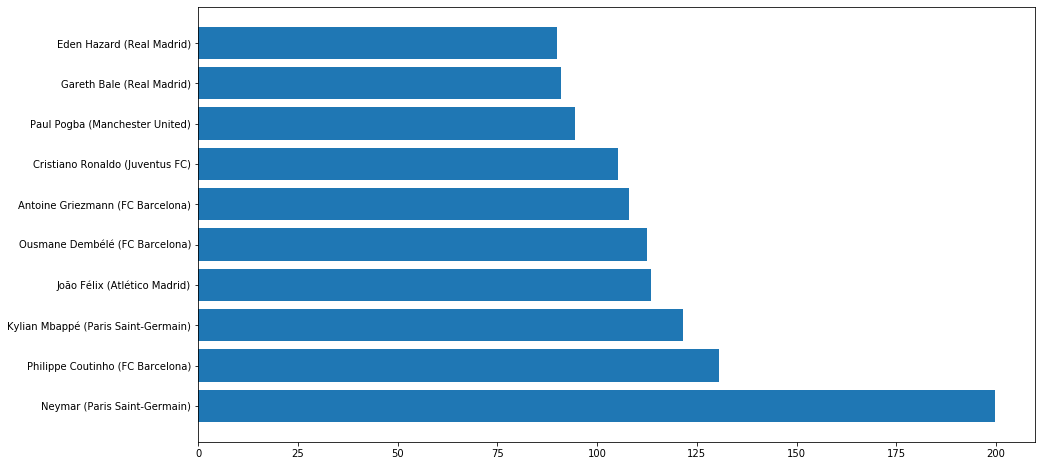

In [12]:

fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(dff['player_name_club'], dff['fee_cleaned'])

In [13]:
colors = dict(zip(
    ['India', 'Europe', 'Asia', 'Latin America',
     'Middle East', 'North America', 'Africa'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50']
))
group_lk = df.set_index('name')['group'].to_dict()

KeyError: "None of ['name'] are in the columns"

Text(1, 0.4, '2019')

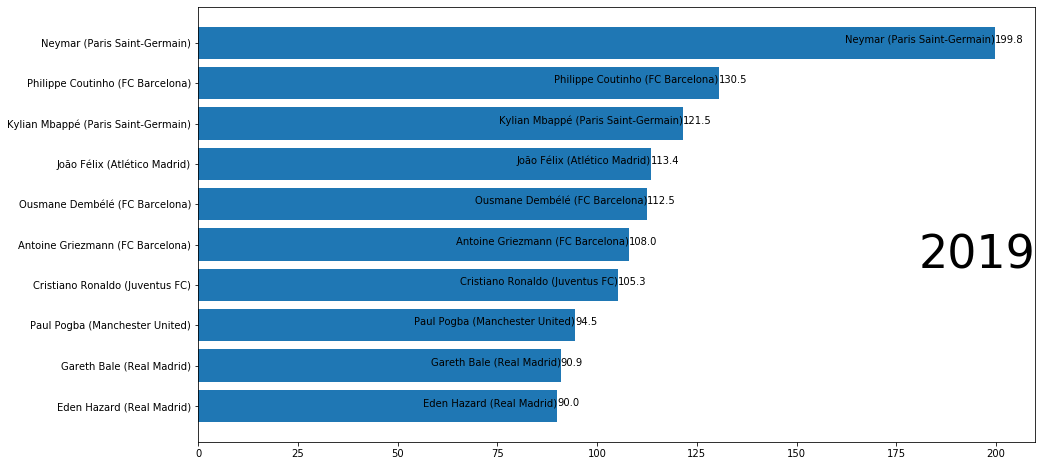

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
dff = dff[::-1]   # flip values from top to bottom
# pass colors values to `color=`
ax.barh(dff['player_name_club'], dff['fee_cleaned'])
# iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
for i, (value, name) in enumerate(zip(dff['fee_cleaned'], dff['player_name_club'])):
    ax.text(value, i,     name,            ha='right')  # Tokyo: name
    #ax.text(value, i-.25, group_lk[name],  ha='right')  # Asia: group name
    ax.text(value, i,     value,           ha='left')   # 38194.2: value
# Add year right middle portion of canvas
ax.text(1, 0.4, current_year, transform=ax.transAxes, size=46, ha='right')

In [15]:
def draw_indiv_barchart(ax,df, position,year):
    df = df[df.generic_position == position]
    dff = df[df['year'].eq(year)].sort_values(by='fee_cleaned', 
                                              ascending=True).tail(5)
    ax.clear()
    ax.set_xlim([0, 250])
    ax.barh(dff['player_name_club'], dff['fee_cleaned'])
    #ax.ylabel(position)
    dx = dff['fee_cleaned'].max() / 200
    
    for i, (value, name) in enumerate(zip(dff['fee_cleaned'], dff['player_name_club'])):
        #ax.text(value+dx, i,     name,    color='#3b4463',       size=22, weight=600, ha='left', va='bottom')
        #ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        #ax.text(value-dx, i,     str('£'+str(value)+'mil'), color = '#ebedf2',  size=14, ha='right',  va='center')
        
        ax.text(value + dx, i + 0.1, '    ' + name, color='#3b4463',size=22, weight=600, 
                ha='left', va='bottom', fontdict = {'fontname': 'Georgia'})
        ax.text(value + dx, i - 0.1, '   £'+str(value)+'mil', size = 18, 
                ha = 'left', va = 'center', fontdict = {'fontname': 'Georgia'})
    
    #ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, '£ (Millions)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=14)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.xaxis.set_ticks_position('top')
    plt.locator_params(axis = 'x', nbins = 4)
    
    ax.text(1, 0, 'by @stefangouyet; data from Transfermarkt', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    
    
    plt.subplots_adjust(left = 0.075, right = 0.75, top = 0.825, bottom = 0.05, wspace = 0.2, hspace = 0.2)
    #plt.locator_params(axis = 'x', nbins = 12)
    plt.box(False)



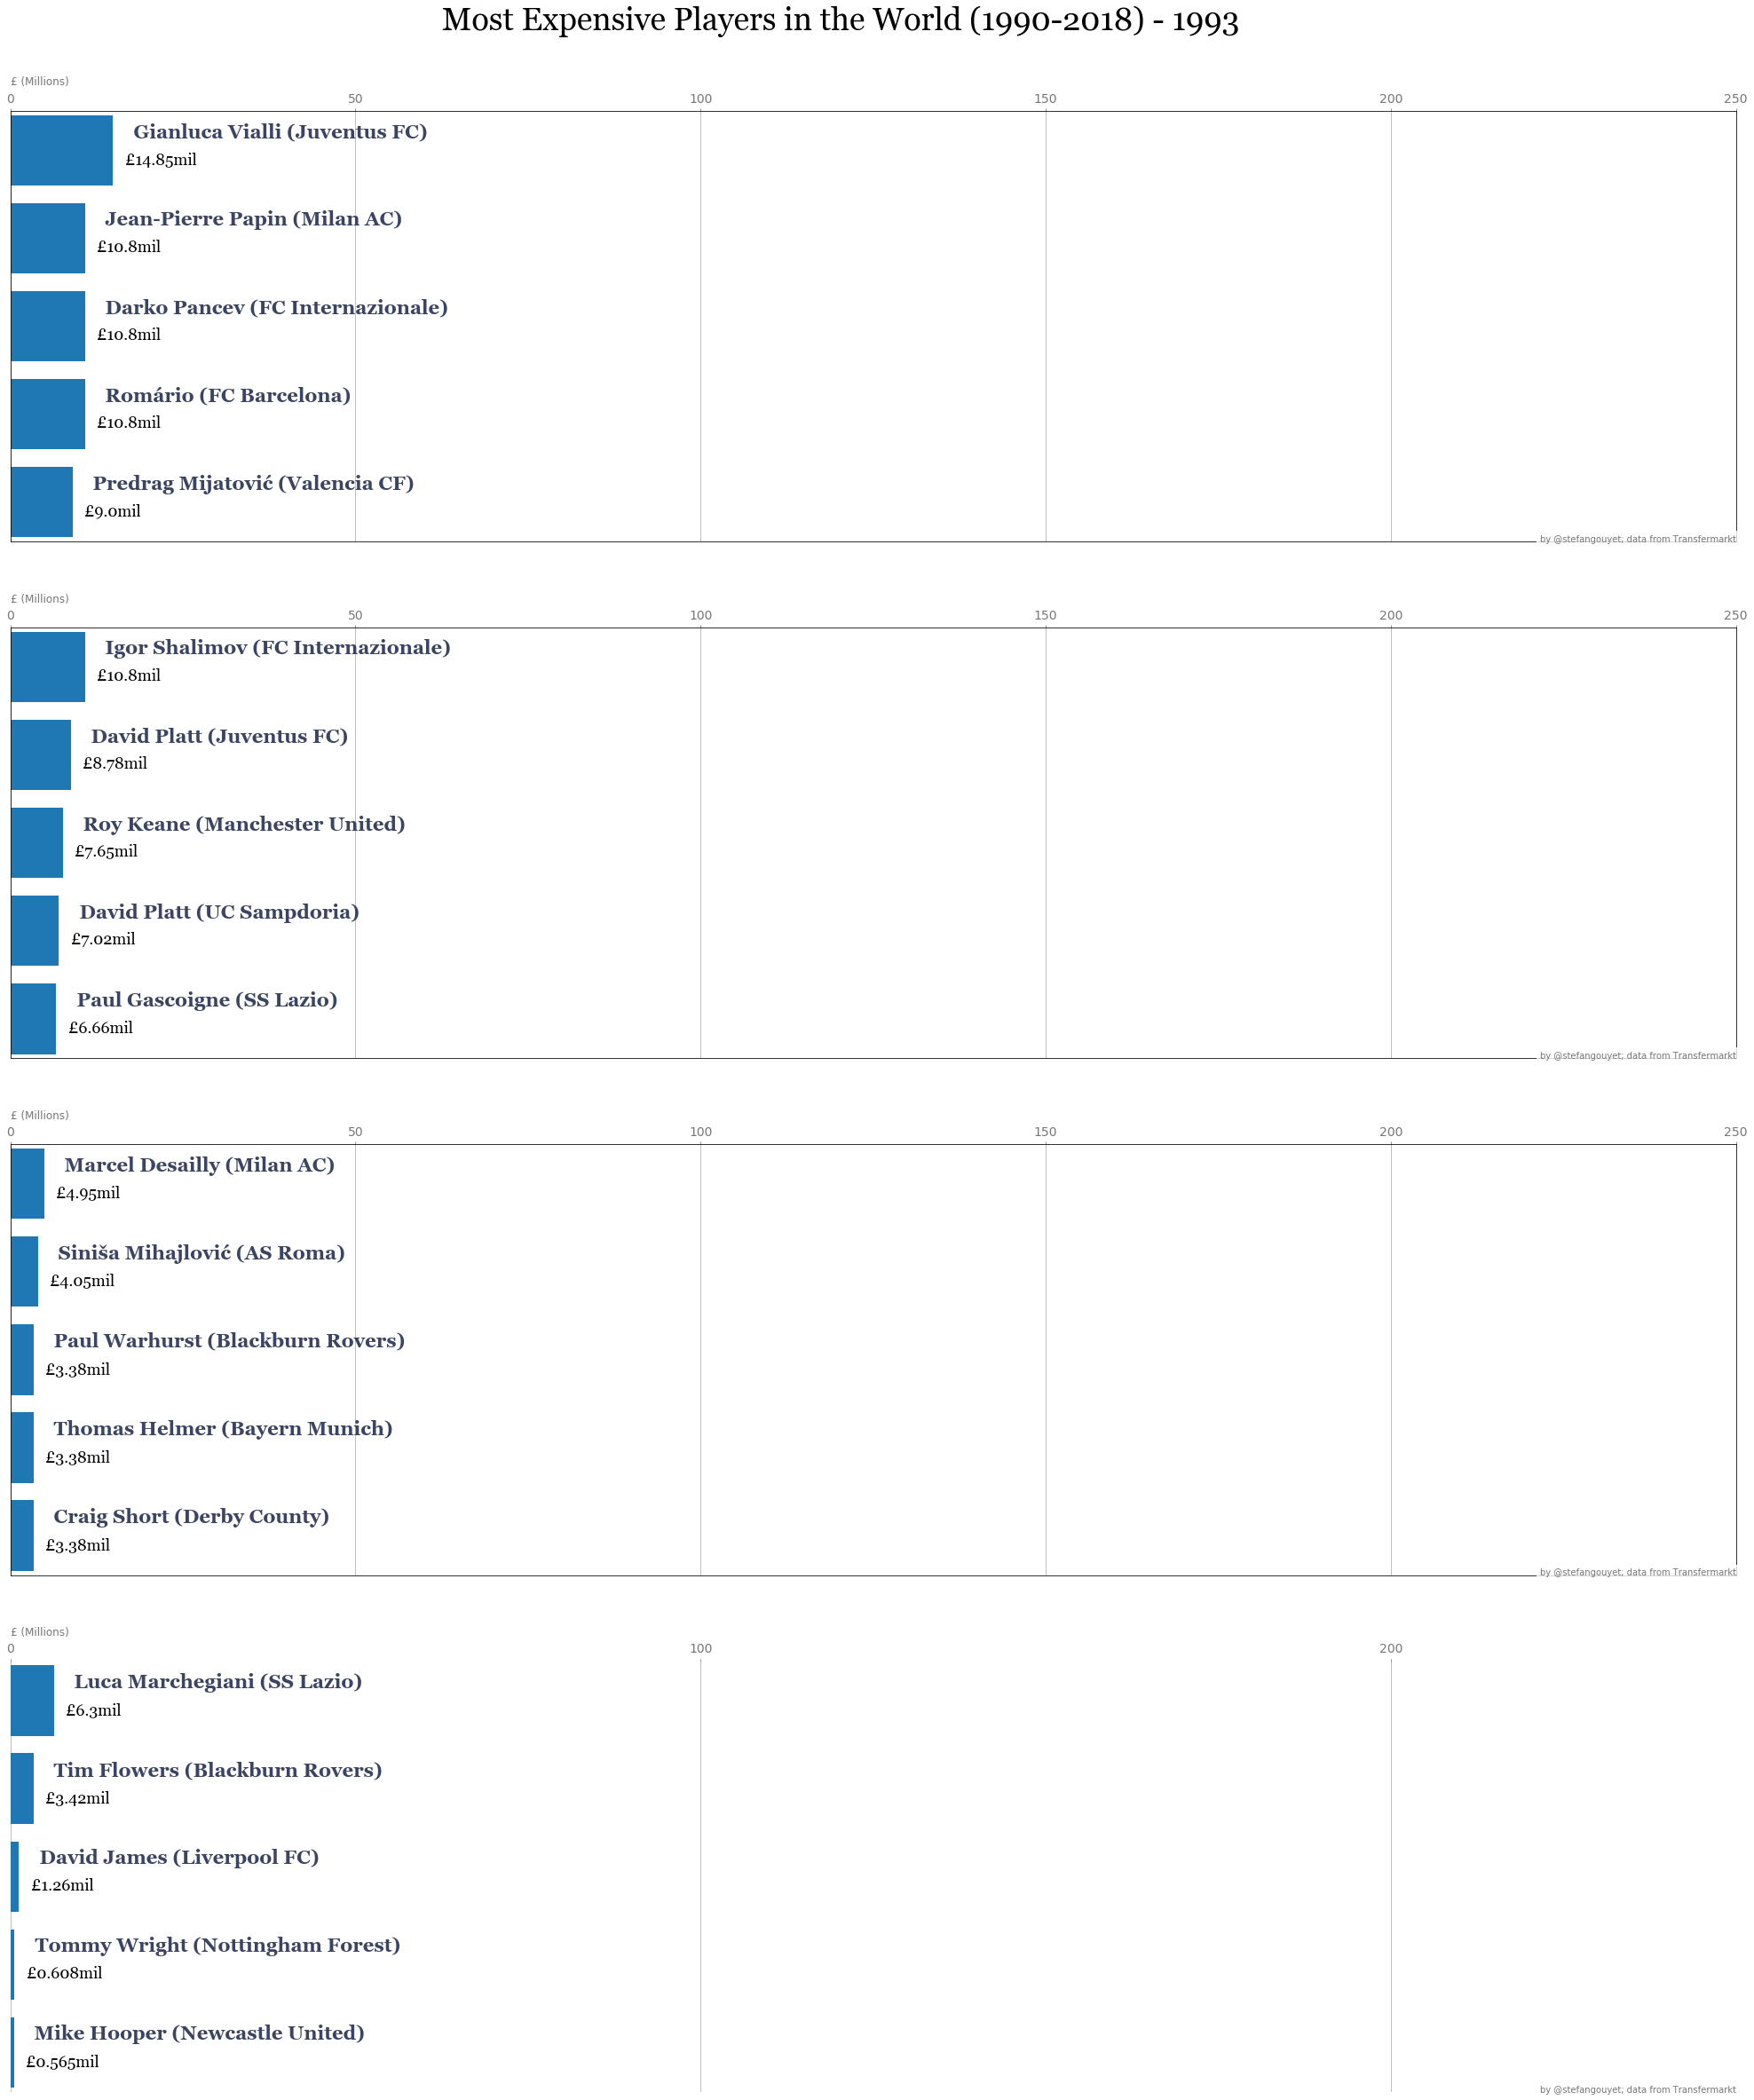

In [16]:
    
#draw_barchart(top_transfers_complete,'Attacker',2018)
#draw_barchart(top_transfers_complete,'Defender',2018)
current_year=1993
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,figsize=(40, 40))
#ax1.text(0, 1.12, 'Most Expensive Players in the World (1990-2018) - {}'.format(current_year),
#            transform=ax.transAxes, size=24, weight=600, ha='center')
fig.suptitle('Most Expensive Players in the World (1990-2018) - {}'.format(current_year), 
             ha='center', va='center', y= 0.86, x = 0.4,
             fontsize=36, fontdict = {'fontname': 'Georgia'})
ax1.set_ylabel('Attacker')

#fig.suptitle('This is a somewhat long figure title', fontsize=16)
draw_indiv_barchart(ax1,top_transfers_complete,'Attacker',current_year)
draw_indiv_barchart(ax2,top_transfers_complete,'Midfielder',current_year)
draw_indiv_barchart(ax3,top_transfers_complete,'Defender',current_year)
draw_indiv_barchart(ax4,top_transfers_complete,'Goalkeeper',current_year)


def draw_subplots(year):
    
    draw_indiv_barchart(ax1,top_transfers_complete,'Attacker',year)
    
    draw_indiv_barchart(ax2,top_transfers_complete,'Midfielder',year)
    ax2.set_ylabel('Midfielder')
    draw_indiv_barchart(ax3,top_transfers_complete,'Defender',year)
    draw_indiv_barchart(ax4,top_transfers_complete,'Goalkeeper',year)
    #fig.xticks(np.arange(0, 250, 50))


AttributeError: 'Figure' object has no attribute 'xticks'

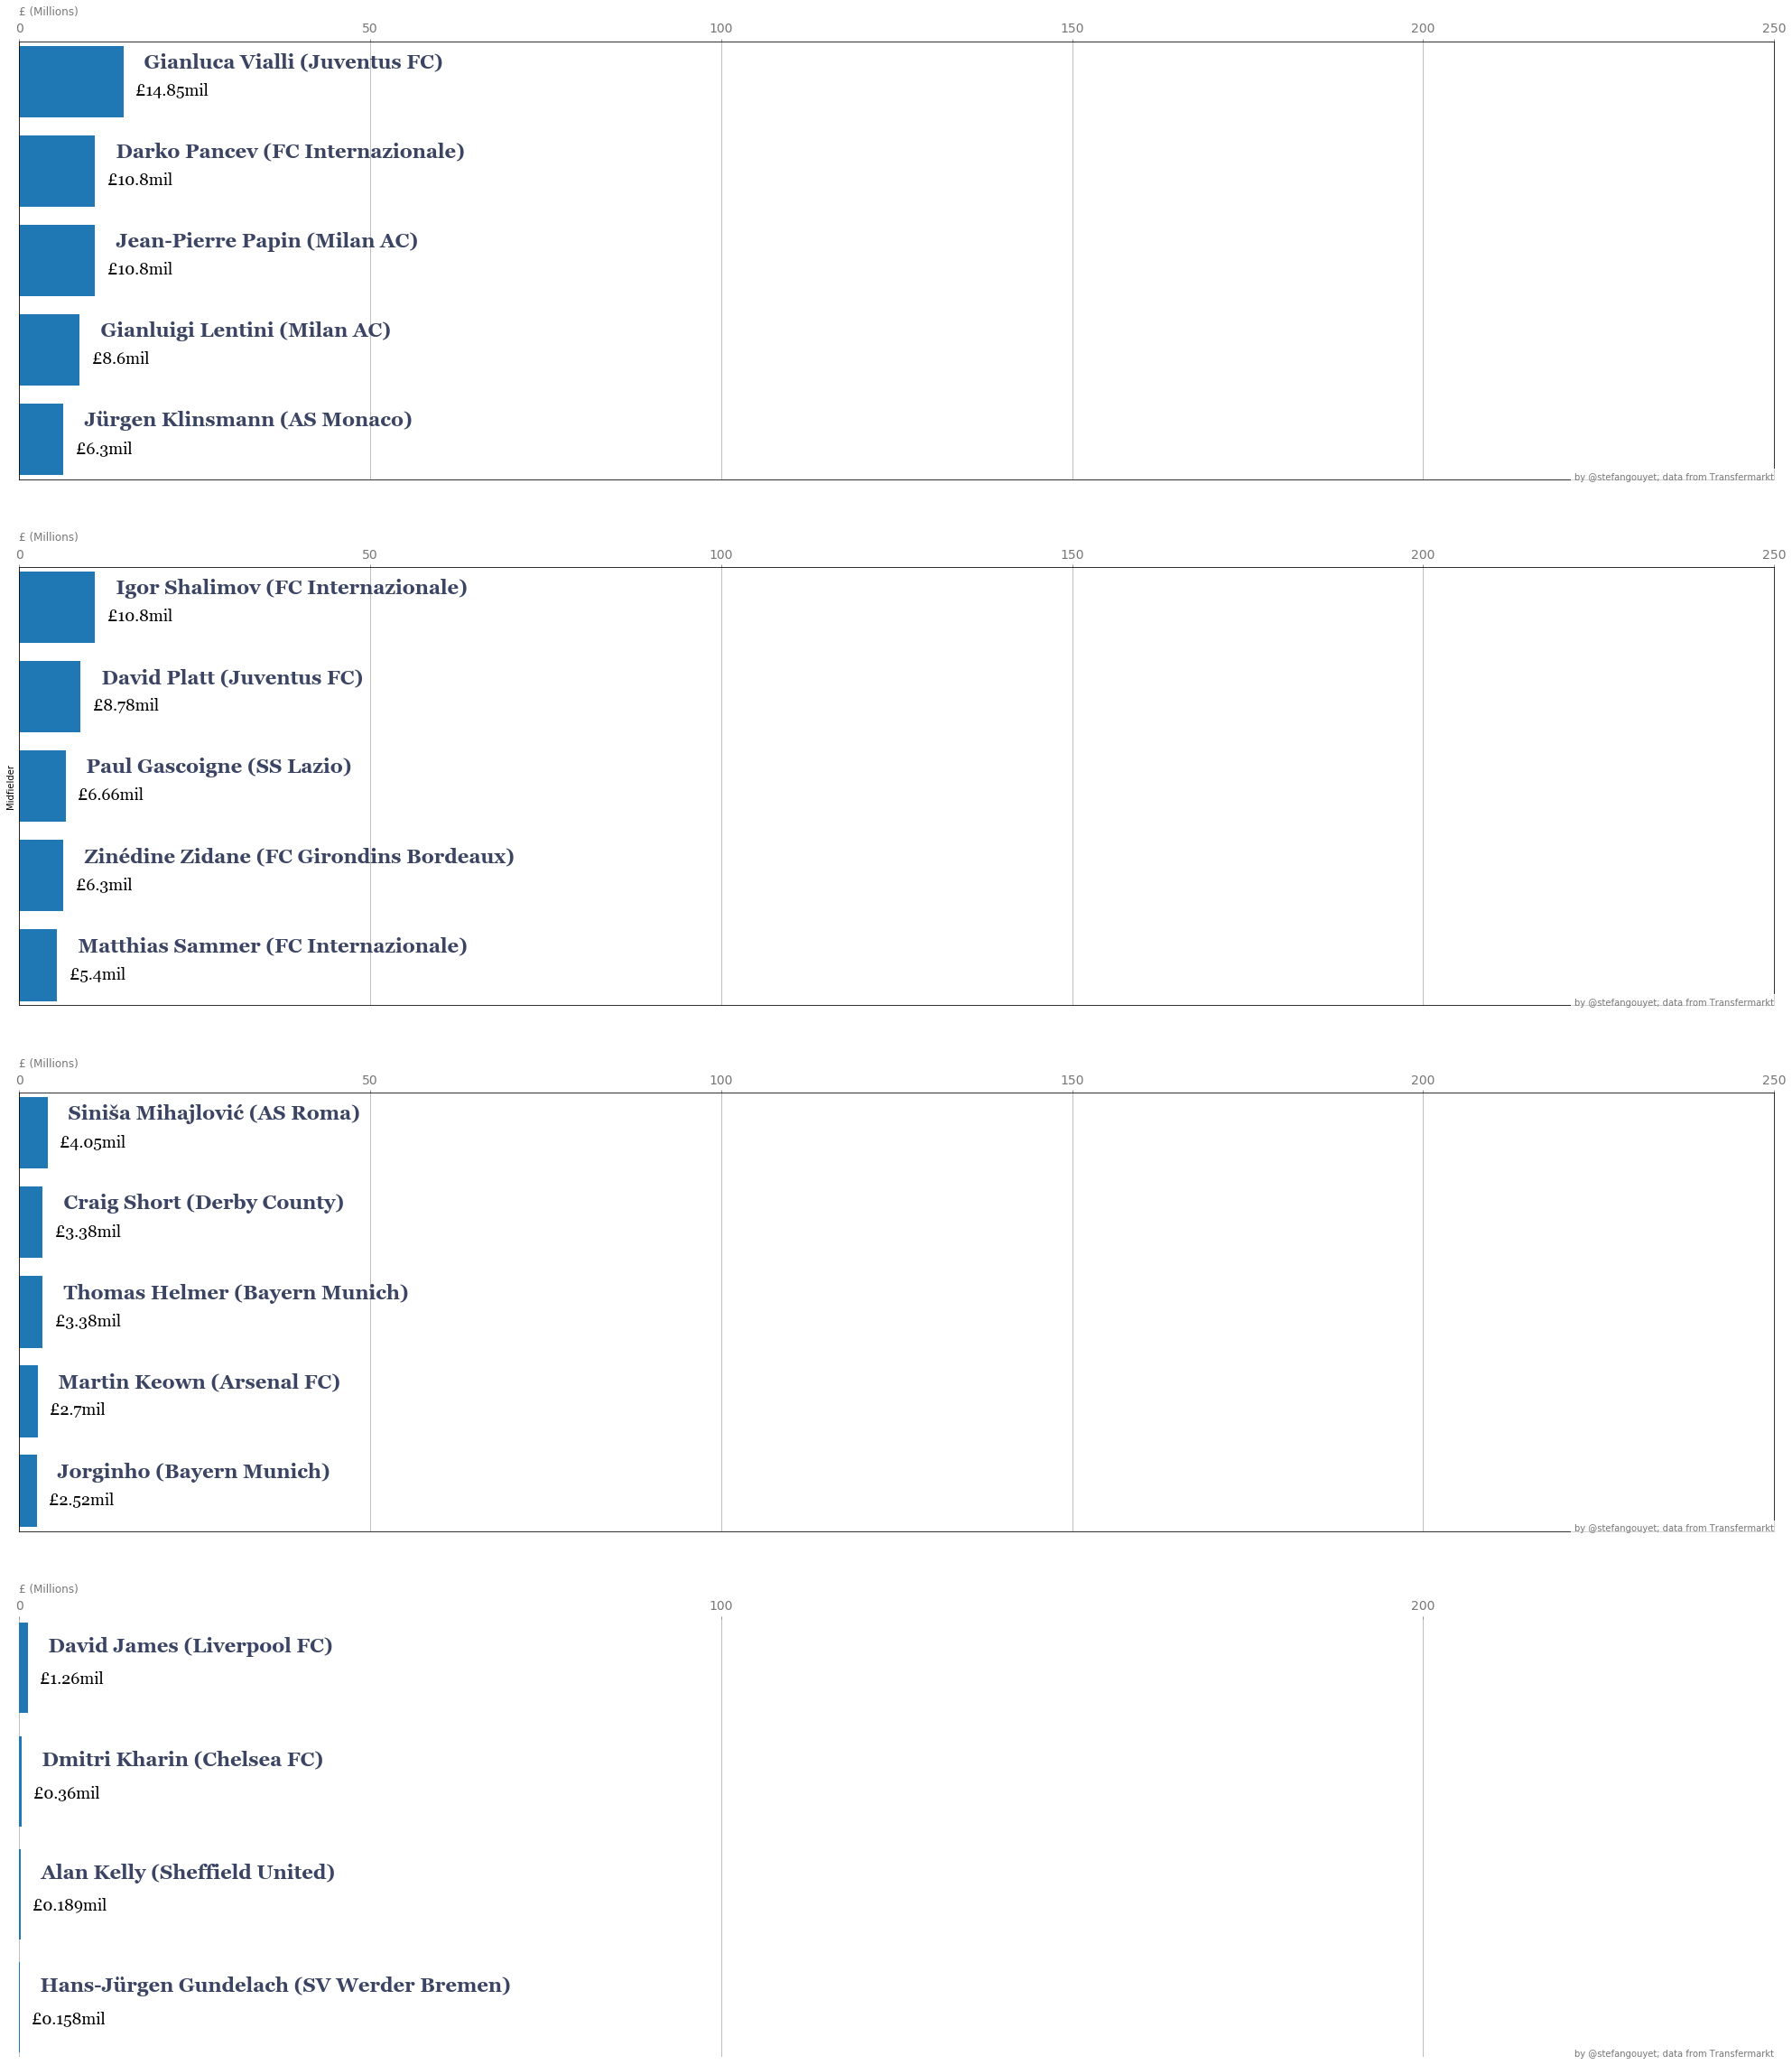

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,figsize=(40, 40))
animator = animation.FuncAnimation(fig, draw_subplots, frames=range(1992, 2019), interval = 250)
HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save()


In [ ]:
ani.save('animation.mp4')

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:

#animator.save("Racing Bar Chart.mp4", )
line_ani.save('lines.mp4', writer=writer,fps = 20, bitrate = 1800)

In [ ]:
animator.to_html5_video('yu1p')